<a href="https://colab.research.google.com/github/jhyeon-kim/ai_study/blob/main/01_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5036075.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65642.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1261572.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5063936.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


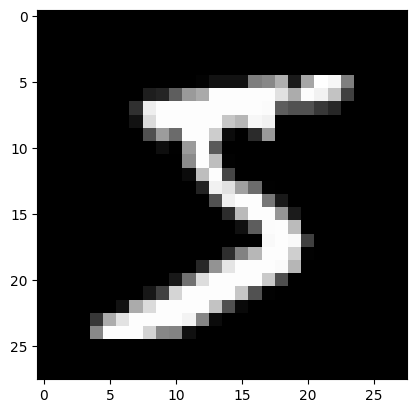

In [ ]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [ ]:
n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 4609.736693739891
Epoch   1 | Loss: 2522.893892765045
Epoch   2 | Loss: 1807.6151924729347
Epoch   3 | Loss: 1422.2451617121696
Epoch   4 | Loss: 1195.491718918085
Epoch   5 | Loss: 1053.6574390232563
Epoch   6 | Loss: 952.1634658575058
Epoch   7 | Loss: 879.042916238308
Epoch   8 | Loss: 818.7386544644833
Epoch   9 | Loss: 771.1778815686703
Epoch  10 | Loss: 729.5409344732761
Epoch  11 | Loss: 693.3726135194302
Epoch  12 | Loss: 660.9100622683764
Epoch  13 | Loss: 631.16512799263
Epoch  14 | Loss: 605.9077615588903
Epoch  15 | Loss: 580.5695589482784
Epoch  16 | Loss: 559.1079169213772
Epoch  17 | Loss: 541.1392047703266
Epoch  18 | Loss: 519.3692178875208
Epoch  19 | Loss: 500.82538667321205
Epoch  20 | Loss: 484.6212624460459
Epoch  21 | Loss: 470.3438350260258
Epoch  22 | Loss: 456.8827604204416
Epoch  23 | Loss: 441.1874012351036
Epoch  24 | Loss: 427.9177328199148
Epoch  25 | Loss: 418.84781112521887
Epoch  26 | Loss: 403.242155469954
Epoch  27 | Loss: 395.31427

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[4.6796]], device='cuda:0', grad_fn=<ReluBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

# 기본과제


- [x]  Test data 준비하기
    - Test data는 MNIST의 train data를 load하는 코드에서 `train=False`로 두면 됩니다.
    - Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
        - Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정합니다.

In [ ]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

- [x]  `nn.CrossEntropyLoss` 적용하기
    - 현재 코드는 regression model을 구현한 상태로, MSE를 loss로 사용하고 있습니다.
    - 하지만 MNIST와 같은 분류 문제에서는 MSE는 적합하지 않습니다.
        - MSE에 따르면 1에 해당하는 손글씨 이미지는 7에 해당하는 손글씨 이미지보다 0에 해당하는 손글씨 이미지가 더 가깝게 여겨집니다.
        - 하지만 1은 실제로 0보다 7과 더 비슷하게 생겼습니다.
    - 일반적으로 분류 문제는 MSE 대신 cross entropy loss를 사용합니다.
    - PyTorch에서의 [cross entropy loss 문서](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 또는 [웹 자료](https://uumini.tistory.com/54)들을 통해 이해한 후, MSE를 대체하는 코드를 구현하시면 됩니다.
        - 변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.

In [ ]:
# 1. 모델의 출력 차원 변경

from torch import nn

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # 0 ~ 9 까지의 숫자로 분류할 것이므로, 분류할 클래스 수는 10

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_2 = Model(28 * 28 * 1, 1024)
# Q. 은닉층의 차원은 1024 로 하는 것이 적절한 이유가 있을까?

In [ ]:
from torch.optim import SGD

lr = 0.001
model_2 = model_2.to('cuda')

# optimizer 선택
optimizer = SGD(model_2.parameters(), lr=lr)

# 손실함수 선택
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss 는 내부적으로 softmax 로 변환하는 과정을 포함

n_epochs = 100

for epoch in range(n_epochs):

  total_loss = 0.
  for data in trainloader:
    model_2.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_2(inputs)
    loss = criterion(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 2129.6247897148132
Epoch   1 | Loss: 2057.4296646118164
Epoch   2 | Loss: 1939.3110617399216
Epoch   3 | Loss: 1735.7920867204666
Epoch   4 | Loss: 1438.385588645935
Epoch   5 | Loss: 1128.7175089716911
Epoch   6 | Loss: 898.3891317844391
Epoch   7 | Loss: 749.6204717159271
Epoch   8 | Loss: 652.2938196361065
Epoch   9 | Loss: 584.740715354681
Epoch  10 | Loss: 535.6166769862175
Epoch  11 | Loss: 498.2350735962391
Epoch  12 | Loss: 468.79651510715485
Epoch  13 | Loss: 444.9579499512911
Epoch  14 | Loss: 425.48983094096184
Epoch  15 | Loss: 409.267250880599
Epoch  16 | Loss: 395.4759897887707
Epoch  17 | Loss: 383.56817977130413
Epoch  18 | Loss: 373.23099306225777
Epoch  19 | Loss: 364.2816619873047
Epoch  20 | Loss: 356.1275096833706
Epoch  21 | Loss: 348.96450117230415
Epoch  22 | Loss: 342.4804094135761
Epoch  23 | Loss: 336.6176057755947
Epoch  24 | Loss: 331.29969008266926
Epoch  25 | Loss: 326.26980759203434
Epoch  26 | Loss: 321.4680659994483
Epoch  27 | Loss: 

- [x]  학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기
    - 다음 조건들 아래에서 학습을 진행하면 됩니다.
        - `n_epochs`=100, `batch_size`=256, `lr`=0.001.
    - 어떤 dataloader에 대한 model의 정확도를 측정하는 코드는 다음 함수를 사용하시면 됩니다:
        
        ```python
        def accuracy(model, dataloader):
          cnt = 0
          acc = 0
        
          for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)
        
            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()
        
          return acc / cnt
        ```
        
    - 추가적으로 구현되어야 하는 부분들을 요약하면 다음과 같습니다:
        - 매 epoch가 끝난 뒤의 model의 `trainloader`와 `testloader`에 대한 정확도를 각각 list로 저장해둡니다.
        - Epoch에 따른 train과 test data에 대한 model의 정확도를 다음 코드를 사용하여 plot합니다:
            
            ```python
            def plot_acc(train_accs, test_accs, label1='train', label2='test'):
              x = np.arange(len(train_accs))
            
              plt.plot(x, train_accs, label=label1)
              plt.plot(x, test_accs, label=label2)
              plt.legend()
              plt.show()
            ```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 학습을 위한 파라미터 설정
n_epochs = 100
batch_size = 256
lr = 0.001

# Dataloader 설정 (batch size 변경된 것으로 반영!)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 손실함수, 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=lr)

# 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval() # 평가모드로 변경 -> dropout, batchnorm 과 같은 동작을 사용하지 않도록
  with torch.no_grad(): # gradient 계산을 할 필요 없으므로 비활성화 (리소스 절약)
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1) # 각 샘플에 대해 가장 높은 점수를 가진 클래스의 인덱스를 반환하는 함수

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item() # label 대로 정확히 맞춘 개수

    model.train()
    return acc / cnt

# 정확도 플롯 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()



Epoch:   1/100 | Loss: 32.7662 | Train Acc: 0.9605 | Test Acc: 0.9576
Epoch:   2/100 | Loss: 32.7272 | Train Acc: 0.9606 | Test Acc: 0.9576
Epoch:   3/100 | Loss: 32.6904 | Train Acc: 0.9606 | Test Acc: 0.9577
Epoch:   4/100 | Loss: 32.5854 | Train Acc: 0.9606 | Test Acc: 0.9577
Epoch:   5/100 | Loss: 32.5503 | Train Acc: 0.9608 | Test Acc: 0.9578
Epoch:   6/100 | Loss: 32.5534 | Train Acc: 0.9608 | Test Acc: 0.9578
Epoch:   7/100 | Loss: 32.4714 | Train Acc: 0.9609 | Test Acc: 0.9580
Epoch:   8/100 | Loss: 32.4285 | Train Acc: 0.9609 | Test Acc: 0.9580
Epoch:   9/100 | Loss: 32.4420 | Train Acc: 0.9609 | Test Acc: 0.9578
Epoch:  10/100 | Loss: 32.3817 | Train Acc: 0.9609 | Test Acc: 0.9580
Epoch:  11/100 | Loss: 32.3705 | Train Acc: 0.9611 | Test Acc: 0.9580
Epoch:  12/100 | Loss: 32.2560 | Train Acc: 0.9612 | Test Acc: 0.9578
Epoch:  13/100 | Loss: 32.1986 | Train Acc: 0.9612 | Test Acc: 0.9581
Epoch:  14/100 | Loss: 32.1588 | Train Acc: 0.9612 | Test Acc: 0.9580
Epoch:  15/100 | Los

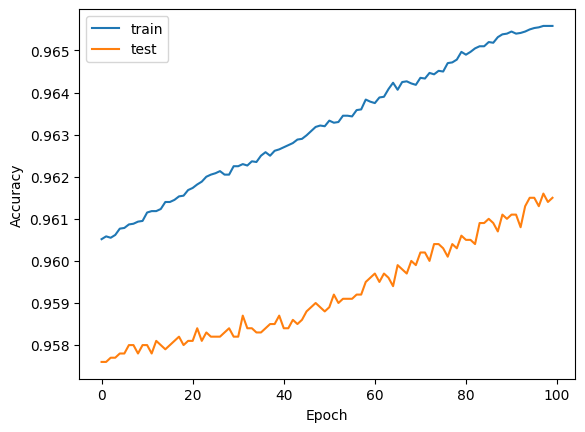

In [ ]:
# 정확도를 저장할 리스트
train_accs = []
test_accs = []

# 매 epoch 마다 train, test 에 대해 정확도 측정
for epoch in range(n_epochs):
  total_loss = 0.

  for data in trainloader:
    model_2.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_2(inputs)
    loss = criterion(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc = accuracy(model_2, trainloader)
  test_acc = accuracy(model_2, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch: {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# 정확도 플롯 그리기
plot_acc(train_accs, test_accs)


# 심화 과제

Classification model을 MNIST에 적용한 코드에서 다음 부분들을 변경하거나 추가해주시면 됩니다:

- [x]  Dataset 및 activation 함수 변경
    - Dataset을 MNIST에서 [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)으로 변경해줍니다.
    - Activation 함수를 `nn.ReLU`에서 `nn.LeakyReLU`로 변경해줍니다.
    - 학습 인자는 `n_epochs` = 50, `batch_size` = 256로 설정합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader 설정
batch_size = 256
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 모델: 활성화 함수를 변경(ReLU -> LeakyReLU)
class Model_Leaky_ReLU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # 데이터셋이 10개 클래스로 분류될 것이므로 출력 차원은 10

    # 활성화 함수
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1) # (n, 3, 32, 32) 로 들어온 입력 x 에 대해 (n, 3 * 32 * 32) 의 2차원으로 만들어주기 (Linear 가 이런 형태의 입력을 받을 수 있어서라고 했던 듯)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model = Model_Leaky_ReLU(3 * 32 * 32, 1024) # 입력 차원 수는 3 * 32 * 32 이고, 동시에 중간 은닉층(?) 의 차원수는 1024 로 설정..

# 학습에 관한 설정
n_epochs = 50
lr = 0.001

model = model.to('cuda') # GPU 사용
criterion = nn.CrossEntropyLoss() # 크로스 엔트로피 를 손실함수로 사용해야 분류 문제에 적합하다고! - 왜?
optimizer = optim.SGD(model.parameters(), lr=lr)

# 정확도 함수 다시 써보기
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval()
  with torch.no_grad(): # gradient 계산을 할 필요 없으므로 비활성화 (리소스 절약)
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      # 각 샘플에 대해 가장 높은 점수를 가진 클래스의 인덱스를 반환하는 함수
      # 예를 들어, 2개 이미지 데이터가 들어왔고, 각각 10개의 클래스 중 하나로 분류하
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    model.train()
    return acc / cnt


Files already downloaded and verified
Files already downloaded and verified


- [x]  CIFAR10의 입력 shape 확인
    - CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
    - 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인해주시면 됩니다.

50000
데이터 크기: torch.Size([3, 32, 32])
레이블 번호 및 해당 클래스: 6 -> frog


Text(0.5, 1.0, 'frog')

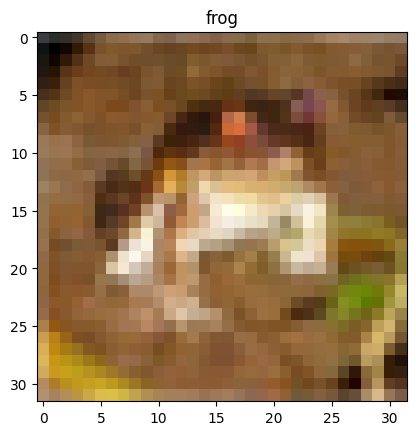

In [ ]:
from matplotlib import pyplot as plt
# CIFAR-10 클래스 목록
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 전체 데이터 개수
print(len(trainset))

# 첫 번째 이미지
image_tensor, label = trainset[0]

# 텐서 크기와 레이블 확인
print(f"데이터 크기: {image_tensor.shape}")
print(f"레이블 번호 및 해당 클래스: {label} -> {classes[label]}")

# 이미지도 보고 싶다..! 정규화 이전 이미지로 변환!!!
image = image_tensor / 2 + 0.5 # 요건 좀 알아봐야 함.

# RGB 고려해서 이미지 출력
image_np = image.permute(1, 2, 0).numpy() # (채널 수, 세로, 가로) -> (세로, 가로, 채널 수)
plt.imshow(image_np)
plt.title(f"{classes[label]}")


# plt.imshow(trainset[0][0][0]) # 이걸로 하면 정규화 때문인지 색이 좀 이상!?



- [ ]  SGD와 Adam 성능 비교
    - 먼저 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)을 사용하여 학습하는 코드를 구현합니다.
    - (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.

Adam | Epoch:   0 | Loss: 321.1313855648041
Adam | Epoch:   1 | Loss: 275.89200460910797
Adam | Epoch:   2 | Loss: 249.690420627594
Adam | Epoch:   3 | Loss: 228.75145757198334
Adam | Epoch:   4 | Loss: 208.34337842464447
Adam | Epoch:   5 | Loss: 187.96251446008682
Adam | Epoch:   6 | Loss: 167.05537861585617
Adam | Epoch:   7 | Loss: 145.8259584903717
Adam | Epoch:   8 | Loss: 126.85284385085106
Adam | Epoch:   9 | Loss: 108.54393166303635
Adam | Epoch:  10 | Loss: 90.91102683544159
Adam | Epoch:  11 | Loss: 80.11896467208862
Adam | Epoch:  12 | Loss: 65.24519236385822
Adam | Epoch:  13 | Loss: 59.71920295059681
Adam | Epoch:  14 | Loss: 49.00108805298805
Adam | Epoch:  15 | Loss: 44.240155190229416
Adam | Epoch:  16 | Loss: 41.75201063603163
Adam | Epoch:  17 | Loss: 39.16161867976189
Adam | Epoch:  18 | Loss: 38.20499483495951
Adam | Epoch:  19 | Loss: 32.74497835338116
Adam | Epoch:  20 | Loss: 33.57974714040756
Adam | Epoch:  21 | Loss: 35.71265158802271
Adam | Epoch:  22 | Loss:

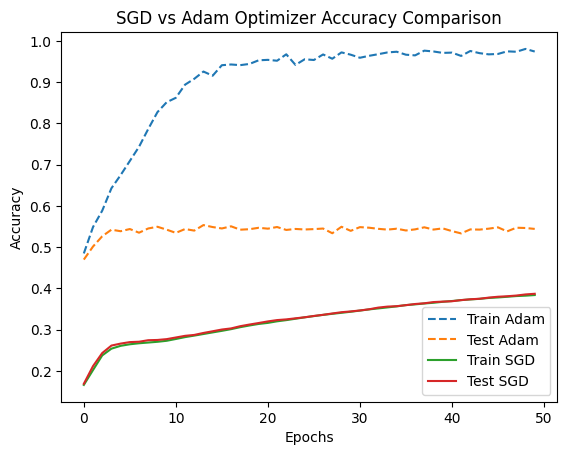

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


optimizer_adam = optim.Adam(model.parameters(), lr=lr)
optimizer_sgd = optim.SGD(model.parameters(), lr=lr)


criterion = nn.CrossEntropyLoss()


def plot_acc(train_accs_adam, train_accs_sgd, test_accs_adam, test_accs_sgd):
    x = np.arange(len(train_accs_adam))

    # Adam과 SGD에 대한 정확도 플롯 그리기
    plt.plot(x, train_accs_adam, label='Train Adam', linestyle='--')
    plt.plot(x, test_accs_adam, label='Test Adam', linestyle='--')

    plt.plot(x, train_accs_sgd, label='Train SGD', linestyle='-')
    plt.plot(x, test_accs_sgd, label='Test SGD', linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('SGD vs Adam Optimizer Accuracy Comparison')
    plt.legend()
    plt.show()

# 정확도 저장 리스트 (Adam & SGD)
train_accs_adam = []
test_accs_adam = []
train_accs_sgd = []
test_accs_sgd = []

# 모델의 파라미터를 초기화하는 함수
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# 학습 전 모델 초기화하는 함수
def reset_model(model):
    model.apply(weight_reset)

# 정확도 저장 리스트 (Adam & SGD)
train_accs_adam = []
test_accs_adam = []
train_accs_sgd = []
test_accs_sgd = []

# Adam 옵티마이저로 학습하기 전에 모델 초기화 (다시 그대로 실행하면 아주 낮은 비용에서 시작함)
reset_model(model)
for epoch in range(n_epochs):
    total_loss = 0.

    for data in trainloader:
        model.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_adam.step()

        total_loss += loss.item()

    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    train_accs_adam.append(train_acc)
    test_accs_adam.append(test_acc)

    print(f"Adam | Epoch: {epoch:3d} | Loss: {total_loss}")

# SGD 옵티마이저로 학습하기 전에 모델 초기화
reset_model(model)
for epoch in range(n_epochs):
    total_loss = 0.

    for data in trainloader:
        model.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_sgd.step()

        total_loss += loss.item()

    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    train_accs_sgd.append(train_acc)
    test_accs_sgd.append(test_acc)

    print(f"SGD | Epoch: {epoch:3d} | Loss: {total_loss}")

# 정확도 플롯 그리기 (Adam vs SGD)
plot_acc(train_accs_adam, train_accs_sgd, test_accs_adam, test_accs_sgd)


- [x]  Leaky ReLU와 Sigmoid 성능 비교
    - Activation 함수가 `nn.Sigmoid`인 class를 새로 정의합니다.
    - (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# 모델: 활성화 함수를 변경(sigmoid)
class Model_Sigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # 데이터셋이 10개 클래스로 분류될 것이므로 출력 차원은 10

    # 활성화 함수
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1) # (n, 3, 32, 32) 로 들어온 입력 x 에 대해 (n, 3 * 32 * 32) 의 2차원으로 만들어주기 (Linear 가 이런 형태의 입력을 받을 수 있어서라고 했던 듯)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_sigmoid = Model_Sigmoid(3 * 32 * 32, 1024) # 입력 차원 수는 3 * 32 * 32 이고, 동시에 중간 은닉층(?) 의 차원수는 1024 로 설정..


# 모델: LeakyReLU
class Model_Leaky_ReLU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # 데이터셋이 10개 클래스로 분류될 것이므로 출력 차원은 10

    # 활성화 함수
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1) # (n, 3, 32, 32) 로 들어온 입력 x 에 대해 (n, 3 * 32 * 32) 의 2차원으로 만들어주기 (Linear 가 이런 형태의 입력을 받을 수 있어서라고 했던 듯)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_leaky_relu = Model_Leaky_ReLU(3 * 32 * 32, 1024) # 입력 차원 수는 3 * 32 * 32 이고, 동시에 중간 은닉층(?) 의 차원수는 1024 로 설정..


In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader 설정
batch_size = 256
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 학습에 관한 설정
n_epochs = 50
lr = 0.001

model_leaky_relu = model_leaky_relu.to('cuda') # GPU 사용
model_sigmoid = model_sigmoid.to('cuda') # GPU 사용

# optimizer 는 Adam 을 사용
optimizer_adam_leaky_relu = optim.Adam(model_leaky_relu.parameters(), lr=lr)
optimizer_adam_sigmoid = optim.Adam(model_sigmoid.parameters(), lr=lr)

# 분류문제니까 여전히 비용은 CrossEntropy 로 계산
criterion = nn.CrossEntropyLoss()

# 활성화 함수를 달리하는 모델별 정확도 저장 리스트 (leaky ReLU & sigmoid)
train_accs_leaky_relu = []
test_accs_leaky_relu = []
train_accs_sigmoid = []
test_accs_sigmoid = []
def plot_acc(train_accs_leaky_relu, train_accs_sigmoid, test_accs_leaky_relu, test_accs_sigmoid):
    x = np.arange(len(train_accs_leaky_relu))

    plt.plot(x, train_accs_leaky_relu, label='Train Leaky ReLU', linestyle='--')
    plt.plot(x, test_accs_leaky_relu, label='Test Leaky ReLU', linestyle='--')

    plt.plot(x, train_accs_sigmoid, label='Train Sigmoid', linestyle='-')
    plt.plot(x, test_accs_sigmoid, label='Test Sigmoid', linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Leaky ReLU vs Sigmoid Accuracy Comparison')
    plt.legend()
    plt.show()

# 정확도 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval()
  with torch.no_grad(): # gradient 계산을 할 필요 없으므로 비활성화 (리소스 절약)
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      # 각 샘플에 대해 가장 높은 점수를 가진 클래스의 인덱스를 반환하는 함수
      # 예를 들어, 2개 이미지 데이터가 들어왔고, 각각 10개의 클래스 중 하나로 분류하
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    model.train()
    return acc / cnt


# 모델의 파라미터를 초기화하는 함수
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# 학습 전 모델 초기화하는 함수
def reset_model(model):
    model.apply(weight_reset)


reset_model(model_leaky_relu)
for epoch in range(n_epochs):
    total_loss = 0.

    for data in trainloader:
        model_leaky_relu.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model_leaky_relu(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_adam_leaky_relu.step()

        total_loss += loss.item()

    train_acc = accuracy(model_leaky_relu, trainloader)
    test_acc = accuracy(model_leaky_relu, testloader)

    train_accs_leaky_relu.append(train_acc)
    test_accs_leaky_relu.append(test_acc)

    print(f"Leaky ReLU | Epoch: {epoch:3d} | Loss: {total_loss}")


reset_model(model_sigmoid)
for epoch in range(n_epochs):
    total_loss = 0.

    for data in trainloader:
        model_sigmoid.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model_sigmoid(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_adam_sigmoid.step()

        total_loss += loss.item()

    train_acc = accuracy(model_sigmoid, trainloader)
    test_acc = accuracy(model_sigmoid, testloader)

    train_accs_sigmoid.append(train_acc)
    test_accs_sigmoid.append(test_acc)

    print(f"Sigmoid | Epoch: {epoch:3d} | Loss: {total_loss}")



Files already downloaded and verified
Files already downloaded and verified
Leaky ReLU | Epoch:   0 | Loss: 320.29580068588257
Leaky ReLU | Epoch:   1 | Loss: 274.80606174468994
Leaky ReLU | Epoch:   2 | Loss: 249.35708785057068
Leaky ReLU | Epoch:   3 | Loss: 228.69688975811005
Leaky ReLU | Epoch:   4 | Loss: 207.86753410100937
Leaky ReLU | Epoch:   5 | Loss: 187.46581411361694
Leaky ReLU | Epoch:   6 | Loss: 166.41387236118317
Leaky ReLU | Epoch:   7 | Loss: 146.0301114320755
Leaky ReLU | Epoch:   8 | Loss: 126.00055143237114
Leaky ReLU | Epoch:   9 | Loss: 108.27916657924652
Leaky ReLU | Epoch:  10 | Loss: 91.5351293683052
Leaky ReLU | Epoch:  11 | Loss: 77.44995084404945
Leaky ReLU | Epoch:  12 | Loss: 66.09091201424599
Leaky ReLU | Epoch:  13 | Loss: 58.6645061224699
Leaky ReLU | Epoch:  14 | Loss: 50.61144642531872
Leaky ReLU | Epoch:  15 | Loss: 46.14988674223423
Leaky ReLU | Epoch:  16 | Loss: 40.441869139671326
Leaky ReLU | Epoch:  17 | Loss: 38.46091954410076
Leaky ReLU | Epo

In [5]:
def plot_acc(train_accs_leaky_relu, train_accs_sigmoid, test_accs_leaky_relu, test_accs_sigmoid):
    x = np.arange(len(train_accs_leaky_relu))

    plt.plot(x, train_accs_leaky_relu, label='Train Leaky ReLU', linestyle='--')
    plt.plot(x, test_accs_leaky_relu, label='Test Leaky ReLU', linestyle='--')

    plt.plot(x, train_accs_sigmoid, label='Train Sigmoid', linestyle='-')
    plt.plot(x, test_accs_sigmoid, label='Test Sigmoid', linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Leaky ReLU vs Sigmoid Accuracy Comparison')
    plt.legend()
    plt.show()

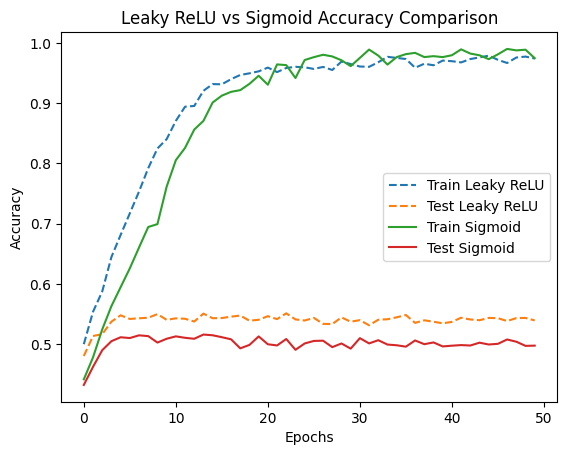

In [6]:
# 정확도 플롯 그리기
plot_acc(train_accs_leaky_relu, train_accs_sigmoid, test_accs_leaky_relu, test_accs_sigmoid)


- [ ]  Dropout을 적용한 이후의 generalization error 확인
    - PyTorch [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.
    - 학습 코드에서 다음 부분들을 추가해줍니다:
        - `model.train()`을 `for data in trainloader:` 이전 줄에 둡니다.
        - `trainloader`와 `testloader`에 대한 정확도를 계산하는 코드를 다음과 같이 변경합니다:
            
            ```python
            with torch.no_grad():
              model.eval()
              <기존 정확도 계산 코드>
            ```
            
    - (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Dropout 추가 모델: LeakyReLU + Dropout
class Model_Leaky_ReLU_Dropout(nn.Module):
    def __init__(self, input_dim, n_dim, dropout_prob=0.1):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10) # 10개의 클래스 분류

        # 활성화 함수 및 Dropout
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)

        return x

# 모델 생성
model_leaky_relu_dropout = Model_Leaky_ReLU_Dropout(3 * 32 * 32, 1024)
model_leaky_relu_dropout = model_leaky_relu_dropout.to('cuda')


In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader 설정
batch_size = 256
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 학습에 관한 설정
n_epochs = 50
lr = 0.001

model_leaky_relu_dropout = model_leaky_relu_dropout.to('cuda') # GPU 사용


# optimizer 는 Adam 을 사용
optimizer_adam_leaky_relu_dropout = optim.Adam(model_leaky_relu_dropout.parameters(), lr=lr)


# 분류문제니까 여전히 비용은 CrossEntropy 로 계산
criterion = nn.CrossEntropyLoss()

# dropout 적용 + leaky relu 활성화 함수 사용 + Adam 옵티마이저 사용할 정확도 저장 리스트
train_accs_leaky_relu_dropout = []
test_accs_leaky_relu_dropout = []


# 정확도 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0


  with torch.no_grad(): # gradient 계산을 할 필요 없으므로 비활성화 (리소스 절약)
    model.eval()
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      # 각 샘플에 대해 가장 높은 점수를 가진 클래스의 인덱스를 반환하는 함수
      # 예를 들어, 2개 이미지 데이터가 들어왔고, 각각 10개의 클래스 중 하나로 분류하
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    return acc / cnt


# 모델의 파라미터를 초기화하는 함수
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# 학습 전 모델 초기화하는 함수
def reset_model(model):
    model.apply(weight_reset)


reset_model(model_leaky_relu_dropout)
for epoch in range(n_epochs):
    total_loss = 0.

    model_leaky_relu_dropout.train()
    for data in trainloader:
        model_leaky_relu_dropout.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model_leaky_relu_dropout(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_adam_leaky_relu_dropout.step()

        total_loss += loss.item()

    train_acc = accuracy(model_leaky_relu_dropout, trainloader)
    test_acc = accuracy(model_leaky_relu_dropout, testloader)

    train_accs_leaky_relu_dropout.append(train_acc)
    test_accs_leaky_relu_dropout.append(test_acc)

    print(f"Leaky ReLU with dropout | Epoch: {epoch:3d} | Loss: {total_loss}")



Files already downloaded and verified
Files already downloaded and verified
Leaky ReLU with dropout | Epoch:   0 | Loss: 323.45313477516174
Leaky ReLU with dropout | Epoch:   1 | Loss: 280.59339797496796
Leaky ReLU with dropout | Epoch:   2 | Loss: 258.9867128133774
Leaky ReLU with dropout | Epoch:   3 | Loss: 239.62474739551544
Leaky ReLU with dropout | Epoch:   4 | Loss: 224.21163636446
Leaky ReLU with dropout | Epoch:   5 | Loss: 209.43002051115036
Leaky ReLU with dropout | Epoch:   6 | Loss: 194.12660717964172
Leaky ReLU with dropout | Epoch:   7 | Loss: 179.77055686712265
Leaky ReLU with dropout | Epoch:   8 | Loss: 165.019689142704
Leaky ReLU with dropout | Epoch:   9 | Loss: 150.13800662755966
Leaky ReLU with dropout | Epoch:  10 | Loss: 137.2753165960312
Leaky ReLU with dropout | Epoch:  11 | Loss: 125.48651829361916
Leaky ReLU with dropout | Epoch:  12 | Loss: 115.63100269436836
Leaky ReLU with dropout | Epoch:  13 | Loss: 104.8886067867279
Leaky ReLU with dropout | Epoch:  14

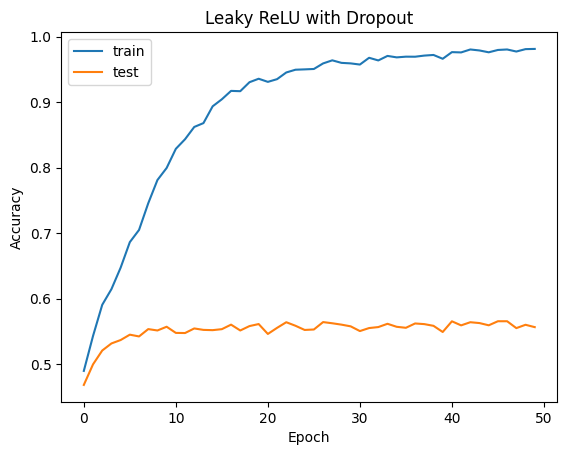

In [11]:
import matplotlib.pyplot as plt
import numpy as np


# 정확도 플롯 함수
def plot_acc(train_accs, test_accs, title, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

# 정확도 플롯 그리기
plot_acc(train_accs_leaky_relu_dropout, test_accs_leaky_relu_dropout, title='Leaky ReLU with Dropout')
